# Surrogate-Based Operability Analysis of an Ethanol–Water Distillation Column (DWSIM + MLP)

**Author:** Nicolas Spogis, Ph.D.
*Founder & Lead Engineer — AI4Tech*

This notebook presents a **realistic industrial workflow** for **operability and flexibility analysis**
applied to a **binary distillation column**, using **Opyrability** and combining:

- a **first-principles (phenomenological) model** executed in **DWSIM** via automation,
- a **data-driven surrogate model** (MLP, *scikit-learn*) trained from simulation data,
- the core operability steps: **forward mapping (AIS → AOS)**,
  **Operability Index**, and **inverse mapping (DOS → DIS\*)**.

The objective is to evaluate **how imposed product-quality and throughput specifications**
translate into **operating requirements**, and to characterize the **feasible operating envelope**
of the distillation column.

---

## Case Study: Ethanol–Water Distillation Column

We analyze a **continuous distillation column** designed to separate an
**ethanol–water mixture**.

In this study, the problem is formulated using an **inverse operability perspective**:
- **product quality** and **throughput-related specifications** are imposed,
- while **operating variables** emerge as required outcomes.

This formulation is particularly suitable for **design-oriented decision making**
and for revealing **trade-offs between separation quality, production rate, and energy consumption**.

<p align="center">
  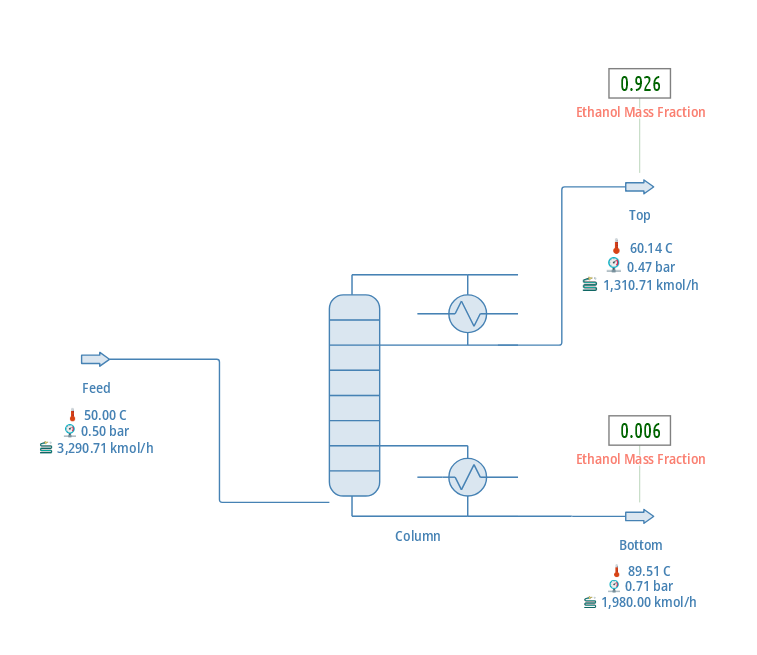
</p>

<p align="center">
  <em>
    Figure 1 – DWSIM flowsheet of the ethanol–water distillation column used as the
    first-principles (phenomenological) model. The column separates an ethanol–water
    mixture, and the operating conditions are inferred from imposed product
    specifications.
  </em>
</p>

---

## Inputs and Outputs Definition

The operability analysis establishes a mapping between the
**Available Input Set (AIS)** — defined here as **imposed specifications** —
and the **Achievable Output Set (AOS)** — defined as the **resulting operating conditions**.

| Variable              | Set | Role            | Unit  | Description                                                        |
|-----------------------|-----|------------------|-------|--------------------------------------------------------------------|
| `x_EtOH_top`          | AIS | Specification    | –     | Ethanol mole fraction in the distillate (top product)              |
| `Bottoms flow`        | AIS | Specification    | molar | Molar flow rate of the bottoms stream (throughput specification)   |
| `Distillate flow`     | AOS | Operating        | molar | Resulting molar flow rate of the distillate stream                 |
| `Reboiler duty`       | AOS | Operating        | MW    | Heat duty required at the reboiler                                  |

> **Interpretation**
> - **AIS** represents the space of **quality and throughput specifications** imposed by the engineer.
> - **AOS** represents the **operating effort and capacity** required to satisfy those specifications.

---

## Available Input Variables (Specifications)

### `x_EtOH_top` — Ethanol Mole Fraction (Distillate)

A **product quality specification** defining the desired ethanol purity in the top product.
Higher values correspond to more demanding separations and typically increase energy consumption.

### `Bottoms flow` — Bottoms Molar Flow Rate

A **throughput-related specification** that controls the material split in the column.
Imposing the bottoms flow introduces an explicit production constraint, which plays a key role
in shaping the achievable operating space.

---

## Achievable Output Variables (Operating Conditions)

### `Distillate flow`

The **resulting production rate** of the distillate stream.
This variable reflects the interaction between imposed quality targets and throughput constraints.

### `Reboiler duty`

The **energy requirement** necessary to achieve the specified separation and throughput.
It captures the thermodynamic cost associated with meeting the imposed specifications.

---

## Modeling and Surrogate Strategy

### 1) DWSIM Phenomenological Model (Ground Truth)

A rigorous **equilibrium-stage distillation column** is modeled in DWSIM and used as the
**reference simulator**.

For multiple combinations of **distillate purity** (`x_EtOH_top`) and
**bottoms molar flow**, the simulator computes the corresponding
**distillate flow rate** and **reboiler duty** required to satisfy those specifications.

This procedure generates a dataset spanning the defined **AIS domain**.

---

### 2) MLP Surrogate Model (Fast Evaluator)

A **Multilayer Perceptron (MLP)** is trained to approximate the nonlinear relationship
between **imposed specifications** and **operating requirements**.

The surrogate represents an **inverse operability mapping**, expressed as:

$\mathbf{u} = [x_{\mathrm{EtOH,top}},\; \dot n_{\mathrm{bottoms}}]^\top
\;\rightarrow\;
\mathbf{y} = [\dot n_{\mathrm{distillate}},\; Q_{\mathrm{reb}}]^\top$.

where:
- $\mathbf{u}$ is the **Available Input Set (AIS)**, defined by product quality and throughput specifications;
- $\mathbf{y}$ is the **Achievable Output Set (AOS)**, representing production rate and energy consumption.

Once trained, the MLP enables **fast evaluation** of operating requirements over large specification domains,
which is essential for dense sampling, feasibility assessment, operability index computation,
and design-oriented inverse analysis.

---

### 3) Operability Workflow (Opyrability)

Using the surrogate model, we compute:

- **Forward mapping (AIS → AOS):** operating conditions resulting from imposed specifications;
- **Operability Index:** quantification of which specification regions are feasible;
- **Inverse mapping (DOS → DIS\*):** identification of specification targets compatible with
  admissible operating limits.

---

## Requirements

This notebook assumes:

- **DWSIM installed** and accessible for automation (Windows / COM environment),
- Python packages (minimum):
  - `opyrability`
  - `numpy`
  - `matplotlib`
  - `scikit-learn`
  - `pythonnet` (DWSIM COM automation / .NET bridge)

---

## Next Step

We begin by importing the required libraries and defining the
**specification-based AIS domain**.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import qmc

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from opyrability import AIS2AOS_map, multimodel_rep, OI_eval, nlp_based_approach


## Connecting to DWSIM

In this step, we load the required **DWSIM libraries** and establish a connection to the
process simulation environment.

This connection allows Python to:
- programmatically load and manipulate the flowsheet,
- modify operating conditions (inputs),
- execute simulations,
- and retrieve results for data generation and analysis.

> **Important:**
> The DWSIM installation path must be updated to match your local system configuration
> before running this section of the notebook.




In [2]:
# Set your DWSIM installation path
DWSIM_PATH = "C:\\Users\\nicol\AppData\\Local\\DWSIM\\" # Update this path

FLOWSHEET_FILE = "ethanol_water_distillation.dwxmz"

In [3]:
import pythoncom
pythoncom.CoInitialize()

import clr

clr.AddReference(str(DWSIM_PATH) + r"\CapeOpen.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Automation.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Interfaces.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.GlobalSettings.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.SharedClasses.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Thermodynamics.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.UnitOperations.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Inspector.dll")
clr.AddReference(str(DWSIM_PATH) + r"\System.Buffers.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Thermodynamics.ThermoC.dll")

In [4]:
from DWSIM.Automation import Automation3

def open_DWSIM(flowsheet_file: str):
    manager = Automation3()
    fs = manager.LoadFlowsheet(flowsheet_file)
    return manager, fs

manager, myflowsheet = open_DWSIM(FLOWSHEET_FILE)
print(f"DWSIM flowsheet loaded -> {FLOWSHEET_FILE}")

DWSIM flowsheet loaded -> ethanol_water_distillation.dwxmz


## Phenomenological Model Wrapper (DWSIM)

In this step, we define a **Python wrapper** around the DWSIM distillation column, which
exposes the phenomenological model as a callable function suitable for operability analysis.

The wrapper function `dc_problem(u)`:
- receives a **specification-based input vector**
  `u = [x_EtOH_top (–), Bottoms flow (molar)]`,
- updates the corresponding specification variables in the DWSIM column model,
- runs the steady-state simulation,
- and returns the resulting **operating outcomes**
  `y = [Distillate flow (molar), Reboiler duty (MW)]`.

This wrapper provides a clean and consistent interface between the
**first-principles separation model** implemented in DWSIM and the subsequent
**surrogate modeling and operability analysis** workflows, ensuring a clear separation
between imposed specifications and resulting operating conditions.


In [5]:
OBJ_DISTILLATION_COLUMN  = "Column"
OBJ_TOP_STREAM  = "Top"
OBJ_BOTTOM_STREAM = "Column"

In [6]:
def dc_problem(Input_Parameters):
    global manager, myflowsheet

    x_EtOH_top = Input_Parameters[0]
    Bottoms_flowrate = Input_Parameters[1]*1000 #kmol/s

    try:
        # Set hot inlet temperature (DWSIM uses Kelvin)
        cscol = myflowsheet.GetFlowsheetSimulationObject(OBJ_DISTILLATION_COLUMN).GetAsObject()
        cscol.SetPropertyValue("Component mole fraction 2 Distillate" , x_EtOH_top)
        cscol.SetPropertyValue("Bottoms flowrate" , Bottoms_flowrate)

        # Solve flowsheet
        manager.CalculateFlowsheet4(myflowsheet)

        if myflowsheet.Solved == False:
            return np.array([np.nan, np.nan], dtype=float)
        else:
            # Read outputs
            Reboiler_duty = float(cscol.GetPropertyValue("Reboiler duty"))/1E6
            stream = myflowsheet.GetFlowsheetSimulationObject(OBJ_TOP_STREAM).GetAsObject()
            Distillate_flow =stream.GetMolarFlow()

            return np.array([float(Distillate_flow), float(Reboiler_duty)], dtype=float)

    except Exception:
        return np.array([np.nan, np.nan], dtype=float)


### Quick Sanity Check

Before proceeding with large-scale data generation and surrogate training,
we perform a quick sanity check to verify that:
- the DWSIM connection is working correctly,
- the wrapper function executes without errors,
- and the returned outputs are physically consistent and within expected ranges.

This step helps catch configuration or modeling issues early,
preventing unnecessary computational effort in later stages.



In [7]:
tests = [
    np.array([0.78, 0.60]),
    np.array([0.78, 0.72]),
    np.array([0.82, 0.60]),
    np.array([0.82, 0.72]),
]

for u in tests:
    y = dc_problem(u)  # [Distillate_flow, Reboiler_duty]
    print(f"u={u} -> y={y}")

Y = np.asarray([dc_problem(u) for u in tests], dtype=float)

print("\nSanity check")
print("Finite:", np.isfinite(Y).all())
print("Distillate flow:", np.nanmin(Y[:,0]), "→", np.nanmax(Y[:,0]))
print("Reboiler duty :", np.nanmin(Y[:,1]), "→", np.nanmax(Y[:,1]))


u=[0.78 0.6 ] -> y=[314.08526  26.7509 ]
u=[0.78 0.72] -> y=[194.08526  17.2226 ]
u=[0.82 0.6 ] -> y=[314.08526  38.0016 ]
u=[0.82 0.72] -> y=[194.08526  24.1768 ]

Sanity check
Finite: True
Distillate flow: 194.08525671601 → 314.08525671601
Reboiler duty : 17.2226 → 38.0016


## Define AIS and Forward Mapping with DWSIM

We now define the **Available Input Set (AIS)** by specifying the admissible ranges for
the **reflux ratio** and the **reboiler duty**. Next, we compute the **forward mapping**
(AIS → AOS) by evaluating the DWSIM distillation column across a grid of operating
conditions.

> **Note (computational cost):**
> Each grid point requires a full steady-state solution of the distillation column in DWSIM.
> Since column convergence can be computationally expensive, the grid resolution should be
> kept **relatively small** in this step to ensure reasonable run time.


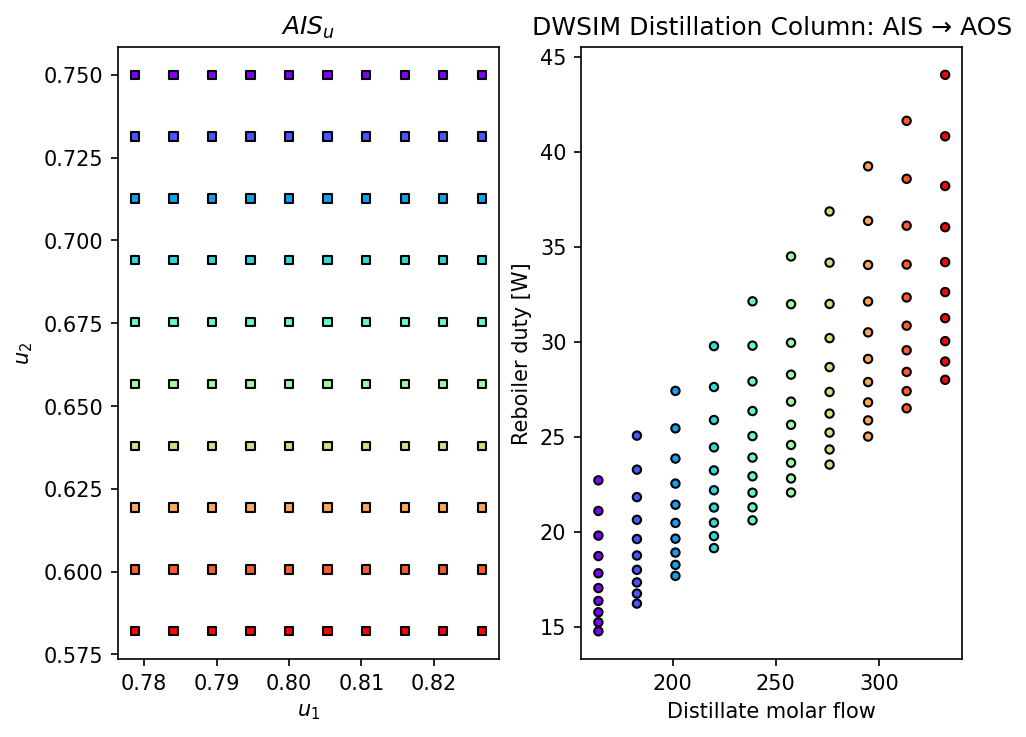

In [8]:
# ------------------------------------------------------------
# Define the Available Input Set (AIS)
# ------------------------------------------------------------
# Each row corresponds to one input variable:
#   [lower_bound, upper_bound]
#
# AIS = [x_EtOH_top, Bottoms_flow]
AIS_bounds = np.array(
    [
        [0.77873621, 0.82662],   # Distillate ethanol mole fraction [-]
        [0.582,      0.75],      # Bottoms_flow [kmol/s]
    ],
    dtype=float
)

# ------------------------------------------------------------
# Number of grid points per AIS dimension.
# Total number of DWSIM simulations = 10 × 10 = 100
resolution_fp = [10, 10]

# ------------------------------------------------------------
# Forward mapping: AIS → AOS using the DWSIM model
# ------------------------------------------------------------
# AOS = [Distillate_flow, Reboiler_duty]
AIS_fp, AOS_fp = AIS2AOS_map(
    dc_problem,      # phenomenological model wrapper
    AIS_bounds,      # input domain (AIS)
    resolution_fp,   # grid resolution
    plot=True        # plot AOS projection
)

# ------------------------------------------------------------
# Plot formatting
# ------------------------------------------------------------
plt.title("DWSIM Distillation Column: AIS → AOS")
plt.xlabel("Distillate molar flow")
plt.ylabel("Reboiler duty [W]")
plt.show()


## Generate Training Data Using Latin Hypercube Sampling (LHS)

To efficiently generate training data for the surrogate model, we employ
**Latin Hypercube Sampling (LHS)** over the defined **AIS domain**.

LHS provides a space-filling sampling strategy that:
- ensures good coverage of the input space with a limited number of samples,
- avoids clustering of points typical of purely random sampling,
- and is well suited for surrogate modeling in nonlinear process systems.

Each sampled point is evaluated using the DWSIM phenomenological model,
producing input–output pairs that will be used to train the MLP surrogate.



In [9]:
# ------------------------------------------------------------
# LHS dataset generation for the Flash case
# ------------------------------------------------------------
n_samples = 1000  # increase if your flowsheet is fast

sampler = qmc.LatinHypercube(d=2, seed=42)
X_unit = sampler.random(n=n_samples)

# Slightly expanded bounds (optional)
l_bounds = [AIS_bounds[0, 0], AIS_bounds[1, 0]]
u_bounds = [AIS_bounds[0, 1], AIS_bounds[1, 1]]

X = qmc.scale(X_unit, l_bounds=l_bounds, u_bounds=u_bounds)

Y = np.full((n_samples, 2), np.nan, dtype=float)

t0 = time.time()
valid = 0

for i in range(n_samples):
    # X[i, :] = [P_flash_bar, T_flash_C]
    y = dc_problem(X[i, :])

    Y[i, :] = y
    if np.all(np.isfinite(y)):
        valid += 1

    if (i + 1) % 25 == 0:
        print(f"{i+1}/{n_samples} evaluated | valid={valid}")

print(f"Elapsed: {time.time() - t0:.1f} s")

# Filter invalid points
mask = np.all(np.isfinite(Y), axis=1)
X = X[mask]
Y = Y[mask]

print("Filtered dataset:", X.shape, Y.shape)


25/1000 evaluated | valid=25
50/1000 evaluated | valid=50
75/1000 evaluated | valid=75
100/1000 evaluated | valid=100
125/1000 evaluated | valid=125
150/1000 evaluated | valid=150
175/1000 evaluated | valid=175
200/1000 evaluated | valid=200
225/1000 evaluated | valid=225
250/1000 evaluated | valid=250
275/1000 evaluated | valid=275
300/1000 evaluated | valid=300
325/1000 evaluated | valid=325
350/1000 evaluated | valid=350
375/1000 evaluated | valid=375
400/1000 evaluated | valid=400
425/1000 evaluated | valid=425
450/1000 evaluated | valid=450
475/1000 evaluated | valid=475
500/1000 evaluated | valid=500
525/1000 evaluated | valid=525
550/1000 evaluated | valid=550
575/1000 evaluated | valid=575
600/1000 evaluated | valid=600
625/1000 evaluated | valid=625
650/1000 evaluated | valid=650
675/1000 evaluated | valid=675
700/1000 evaluated | valid=700
725/1000 evaluated | valid=725
750/1000 evaluated | valid=750
775/1000 evaluated | valid=775
800/1000 evaluated | valid=800
825/1000 evalu

## Train a Multi-Output MLP Surrogate Model

In this step, we train a **multi-output Multilayer Perceptron (MLP)** to approximate the
input–output behavior of the DWSIM phenomenological model.

Both **inputs and outputs are scaled** prior to training in order to:
- improve numerical conditioning,
- stabilize gradient-based optimization,
- and ensure balanced learning across variables with different magnitudes and units.

The trained surrogate provides a fast and smooth approximation of the process behavior,
making it suitable for forward mapping, inverse mapping, and operability analysis.



In [10]:
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

# Scaling (important for smooth tanh MLP + inverse optimization stability)
scalerX = StandardScaler()
scalerY = StandardScaler()

Xtr = scalerX.fit_transform(X_train)
Ytr = scalerY.fit_transform(Y_train)

Xte = scalerX.transform(X_test)

# Robust MLP for inverse operability (smooth + regularized + early stopping)
mlp = MLPRegressor(
    hidden_layer_sizes=(32, 32),
    activation="tanh",
    solver="adam",
    alpha=1e-3,
    learning_rate_init=5e-4,
    max_iter=8000,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=30,
    tol=1e-6,
    random_state=42
)

mlp.fit(Xtr, Ytr)

# Predict (bring back to physical units)
Y_pred = scalerY.inverse_transform(mlp.predict(Xte))

# Metrics (Distillate flow, Reboiler duty)
print("R2 Distillate flow:", r2_score(Y_test[:, 0], Y_pred[:, 0]))
print("R2 Reboiler duty  :", r2_score(Y_test[:, 1], Y_pred[:, 1]))

print("RMSE Distillate flow:", np.sqrt(mean_squared_error(Y_test[:, 0], Y_pred[:, 0])))
print("RMSE Reboiler duty  :", np.sqrt(mean_squared_error(Y_test[:, 1], Y_pred[:, 1])))

R2 Distillate flow: 0.9999659097866115
R2 Reboiler duty  : 0.9998542531165813
RMSE Distillate flow: 0.28670408836714606
RMSE Reboiler duty  : 0.07460979874770972


## Surrogate Model Wrapper and Forward Mapping (AIS → AOS)

In this section, we wrap the trained **MLP surrogate model** into a callable function
that mirrors the interface of the phenomenological DWSIM distillation column.

In the current formulation, the surrogate wrapper:
- receives a **specification-based input vector**
  `u = [x_EtOH_top (–), Bottoms flow (molar)]`,
- applies the appropriate input scaling,
- evaluates the trained MLP surrogate,
- and returns the **resulting operating conditions** in physical units.

Using this wrapper, we efficiently compute the **forward mapping (AIS → AOS)**,
where **imposed quality and throughput specifications** are mapped to the
corresponding **operating outcomes**, namely the **distillate flow rate**
and the **reboiler heat duty**.

This approach enables dense sampling of the **achievable operating space**
without the computational cost of repeatedly solving the full DWSIM flowsheet.

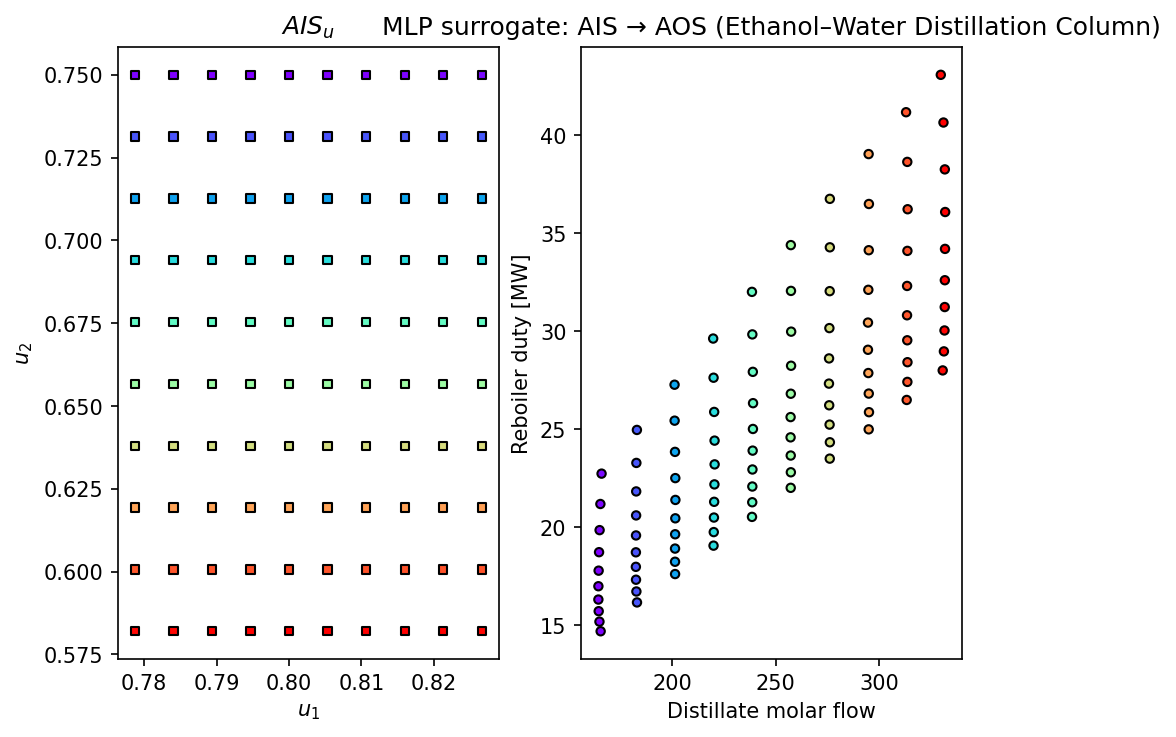

In [11]:
def mlp_surrogate(u):
    # u = [x_EtOH_top, Bottoms_flow]
    u = np.asarray(u, dtype=float).reshape(1, -1)
    y_scaled = mlp.predict(scalerX.transform(u))
    y = scalerY.inverse_transform(y_scaled)
    return y.reshape(-1)  # [Distillate_flow, Reboiler_duty]


# Surrogate forward mapping resolution
resolution_surr = [10, 10]

AIS_s, AOS_s = AIS2AOS_map(
    mlp_surrogate,
    AIS_bounds,
    resolution_surr,
    plot=True
)

plt.title("MLP surrogate: AIS → AOS (Ethanol–Water Distillation Column)")
plt.xlabel("Distillate molar flow")
plt.ylabel("Reboiler duty [MW]")
plt.show()

## Operability Index (OI)

The **Operability Index (OI)** quantifies how much of a **desired operating region**
in the output space can be achieved by the process given the defined **AIS**.

In practical terms, the OI measures:
- the degree of operational flexibility of the system,
- how restrictive the process is with respect to output specifications,
- and whether the desired performance targets are realistically attainable.

An OI value close to **1** indicates high operability (most of the desired region is
reachable), while values close to **0** indicate limited or poor operability.

In this notebook, the OI is computed using the surrogate-based AOS,
enabling efficient evaluation of different operating specifications.



In [12]:
# ------------------------------------------------------------
# Define the Desired Output Set (DOS)
# ------------------------------------------------------------
# Each row corresponds to one OUTPUT variable (AOS):
#   [lower_bound, upper_bound]
#
# In this inverse operability formulation:
#   - Outputs correspond to OPERATING RESULTS
#   - DOS defines acceptable operating outcomes
#     resulting from imposed quality and throughput specifications
#
# AOS variables:
#
# 1) Distillate flow [molar]
#    Acceptable production range for the distillate stream.
#
# 2) Reboiler duty [MW]
#    Acceptable energy consumption range required
#    to satisfy the imposed specifications.
#

DOS_bounds = np.array(
    [
        [200.0, 320.0],   # Distillate molar flow
        [20.0, 38.0],     # Reboiler duty [MW]
    ],
    dtype=float
)



Computing AOS using the first-principles (DWSIM) model...


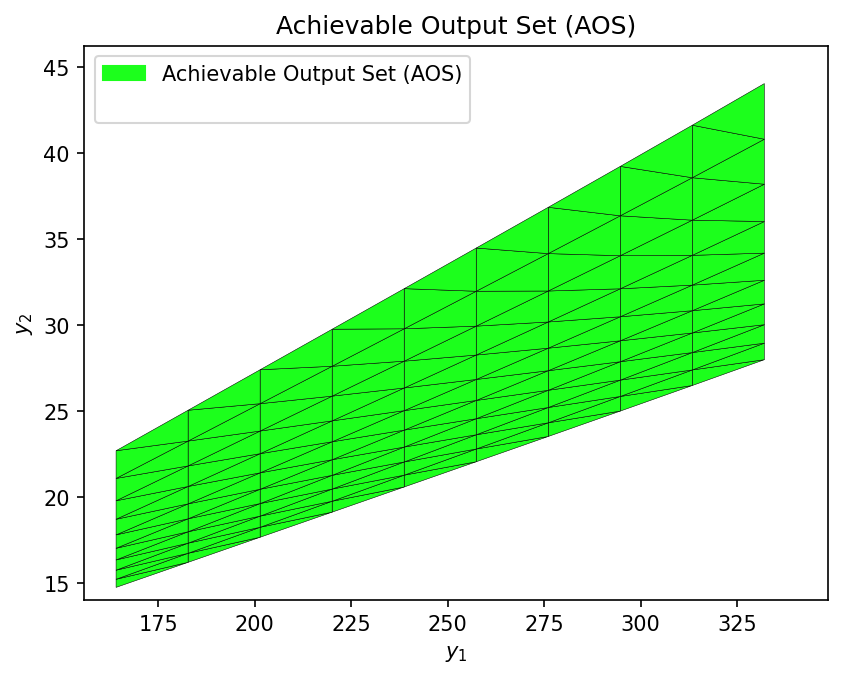

  Completed in 55.23 seconds

Computing AOS using the MLP surrogate model...


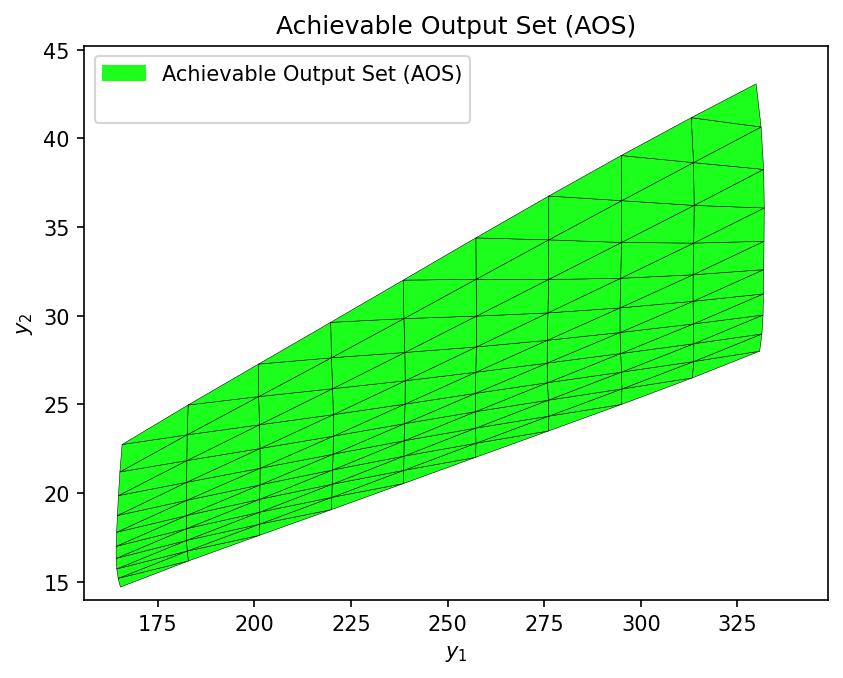

  Completed in 0.38 seconds


In [13]:
# ------------------------------------------------------------
# Define AIS resolution for multimodel representation
# ------------------------------------------------------------
# Number of discretization points per AIS dimension.
# This grid is used to compute the Achievable Output Set (AOS)
# using different process models.
AIS_resolution = [10, 10]

# ------------------------------------------------------------
# Multimodel AOS computation — First-principles (DWSIM) model
# ------------------------------------------------------------
print("\nComputing AOS using the first-principles (DWSIM) model...")
start_fp_mm = time.time()

AOS_fp = multimodel_rep(
    dc_problem,      # phenomenological model wrapper
    AIS_bounds,      # AIS domain
    AIS_resolution   # discretization resolution
)

time_fp_mm = time.time() - start_fp_mm
print(f"  Completed in {time_fp_mm:.2f} seconds")

# ------------------------------------------------------------
# Multimodel AOS computation — Surrogate (MLP) model
# ------------------------------------------------------------
print("\nComputing AOS using the MLP surrogate model...")
start_surr_mm = time.time()

AOS_surr = multimodel_rep(
    mlp_surrogate,   # trained surrogate model wrapper
    AIS_bounds,      # AIS domain
    AIS_resolution   # discretization resolution
)

time_surr_mm = time.time() - start_surr_mm
print(f"  Completed in {time_surr_mm:.2f} seconds")


**First-Principles Model — Operability Index (OI)**


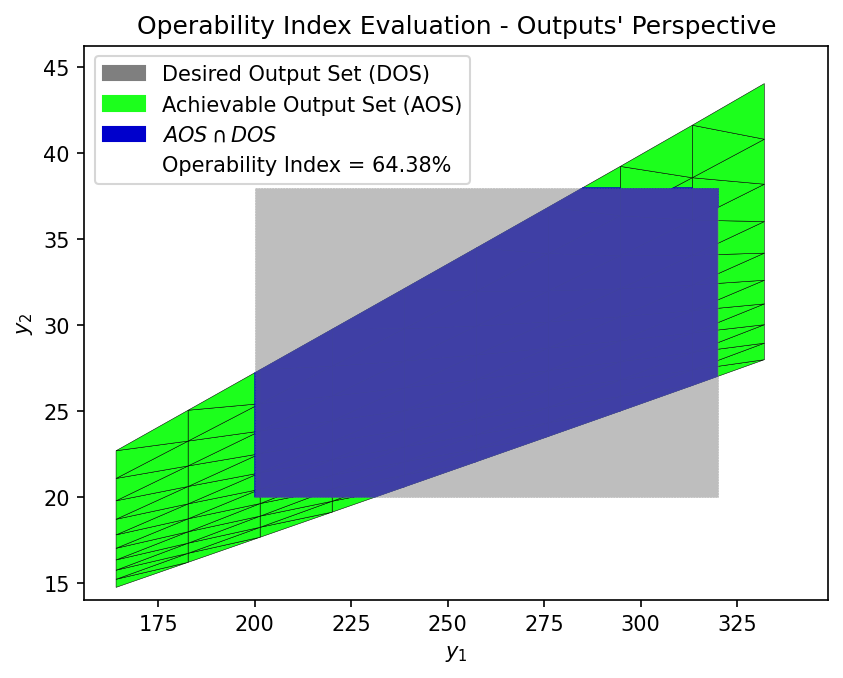

In [14]:
OI_fp = OI_eval(AOS_fp, DOS_bounds, plot=True)

**Operability Index (OI) — Surrogate Model**

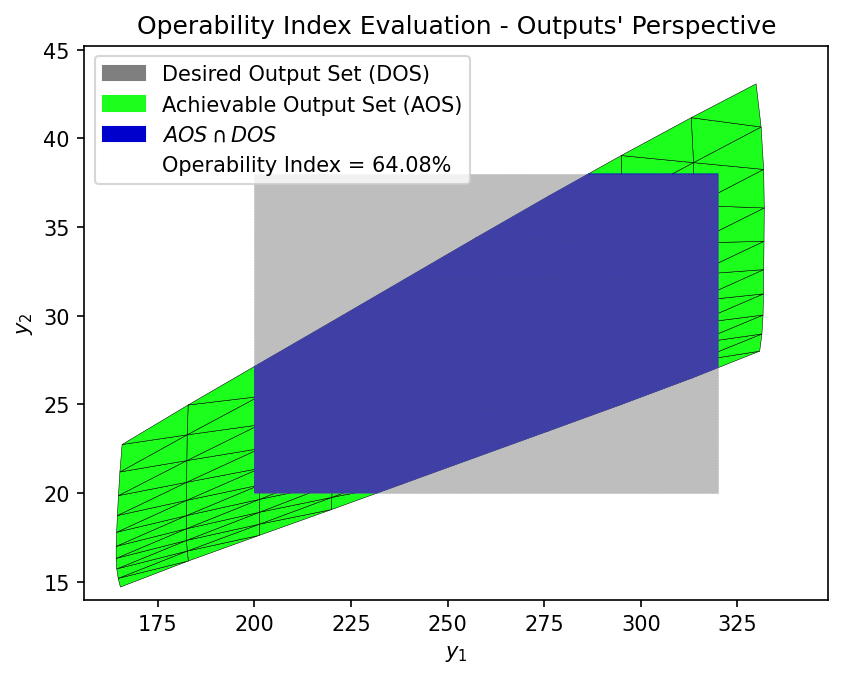

In [15]:
OI_surr = OI_eval(AOS_surr, DOS_bounds, plot=True)

In [16]:
# ------------------------------------------------------------
# Operability Index (OI) comparison summary
# ------------------------------------------------------------
# This section compares:
#  - OI computed with the first-principles (DWSIM) model
#  - OI computed with the surrogate (MLP) model
#  - Computational cost of each approach
# ------------------------------------------------------------

print("\n" + "=" * 60)
print("OPERABILITY INDEX COMPARISON")
print("=" * 60)

# Table header
print(
    f"\n  {'Metric':<25}"
    f"{'First-Principles':>18}"
    f"{'Surrogate Model':>18}"
)

# Separator
print(
    f"  {'-'*25}"
    f"{'-'*18}"
    f"{'-'*18}"
)

# Operability Index values
print(
    f"  {'OI Value':<25}"
    f"{OI_fp:>17.2f}%"
    f"{OI_surr:>17.2f}%"
)

# Multimodel computation time
print(
    f"  {'Multimodel Time [s]':<25}"
    f"{time_fp_mm:>18.2f}"
    f"{time_surr_mm:>18.2f}"
)

# ------------------------------------------------------------
# Accuracy and performance metrics
# ------------------------------------------------------------

# Relative error between OI values
relative_error_oi = abs(OI_fp - OI_surr) / OI_fp * 100

# Speedup factor of surrogate vs first-principles
speedup = time_fp_mm / time_surr_mm

print(f"\n  Relative Error in OI: {relative_error_oi:.2f}%")
print(f"  Speedup: {speedup:.1f}× faster")



OPERABILITY INDEX COMPARISON

  Metric                     First-Principles   Surrogate Model
  -------------------------------------------------------------
  OI Value                             64.38%            64.08%
  Multimodel Time [s]                   55.23              0.38

  Relative Error in OI: 0.46%
  Speedup: 144.3× faster


## Inverse Mapping (DOS → DIS\*) via Nonlinear Programming (NLP)

In this section, we perform the **inverse operability analysis**, where the goal is to
determine the set of input conditions that can achieve a **Desired Output Set (DOS)**.

Instead of mapping inputs to outputs, we solve the inverse problem:
given a target region in the output space, find the corresponding **Desired Input Set**
that satisfies these specifications.

This inverse mapping is formulated as a **nonlinear programming (NLP)** problem,
typically solved using the **surrogate model** to ensure computational efficiency.

The resulting **DIS\*** represents the subset of the AIS that can reliably drive the
process into the desired operating region.


**First-Principles Model (DWSIM)**

Running inverse mapping with First-Principles Model...


100%|██████████| 100/100 [2:19:06<00:00, 83.47s/it]  


Completed in 8346.86 seconds


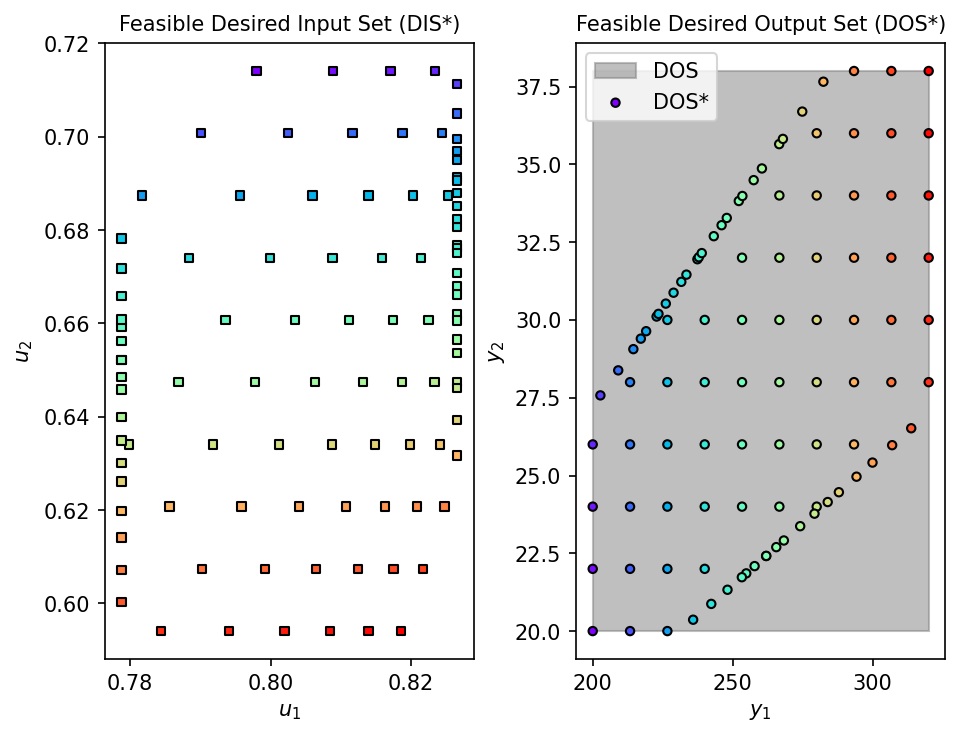

In [17]:
DOS_resolution = [10, 10]

lb = np.array([AIS_bounds[0,0], AIS_bounds[1,0]], dtype=float)
ub = np.array([AIS_bounds[0,1], AIS_bounds[1,1]], dtype=float)
u0 = np.array([0.8, 0.65], dtype=float)

# Inverse mapping with First-Principles Model
print("Running inverse mapping with First-Principles Model...")
start_fp = time.time()
fDIS_fp, fDOS_fp, conv_fp = nlp_based_approach(
    dc_problem, DOS_bounds, DOS_resolution, u0, lb, ub,
    constr=None, method="Nelder-Mead", plot=True, ad=False, warmstart=False
)

time_fp = time.time() - start_fp
print(f"Completed in {time_fp:.2f} seconds")

**Surrogate Model (MLP)**

Running inverse mapping with MLP Surrogate Model...


100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


Completed in 5.38 seconds


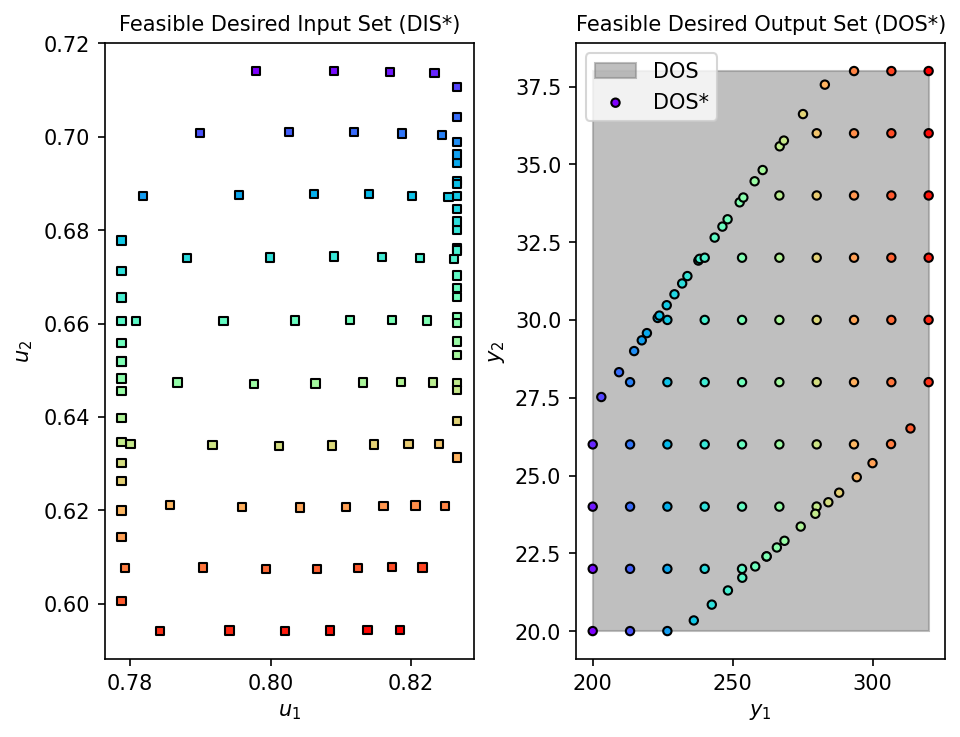

In [18]:
DOS_resolution = [10, 10]

lb = np.array([AIS_bounds[0,0], AIS_bounds[1,0]], dtype=float)
ub = np.array([AIS_bounds[0,1], AIS_bounds[1,1]], dtype=float)
u0 = np.array([0.8, 0.65], dtype=float)

# Inverse mapping with MLP Surrogate Model
print("Running inverse mapping with MLP Surrogate Model...")
start_surr = time.time()

fDIS_surr, fDOS_surr, conv_surr = nlp_based_approach(
    mlp_surrogate, DOS_bounds, DOS_resolution, u0, lb, ub,
    constr=None, method="Nelder-Mead", plot=True, ad=False, warmstart=False
)

time_surrogate = time.time() - start_surr
print(f"Completed in {time_surrogate:.2f} seconds")

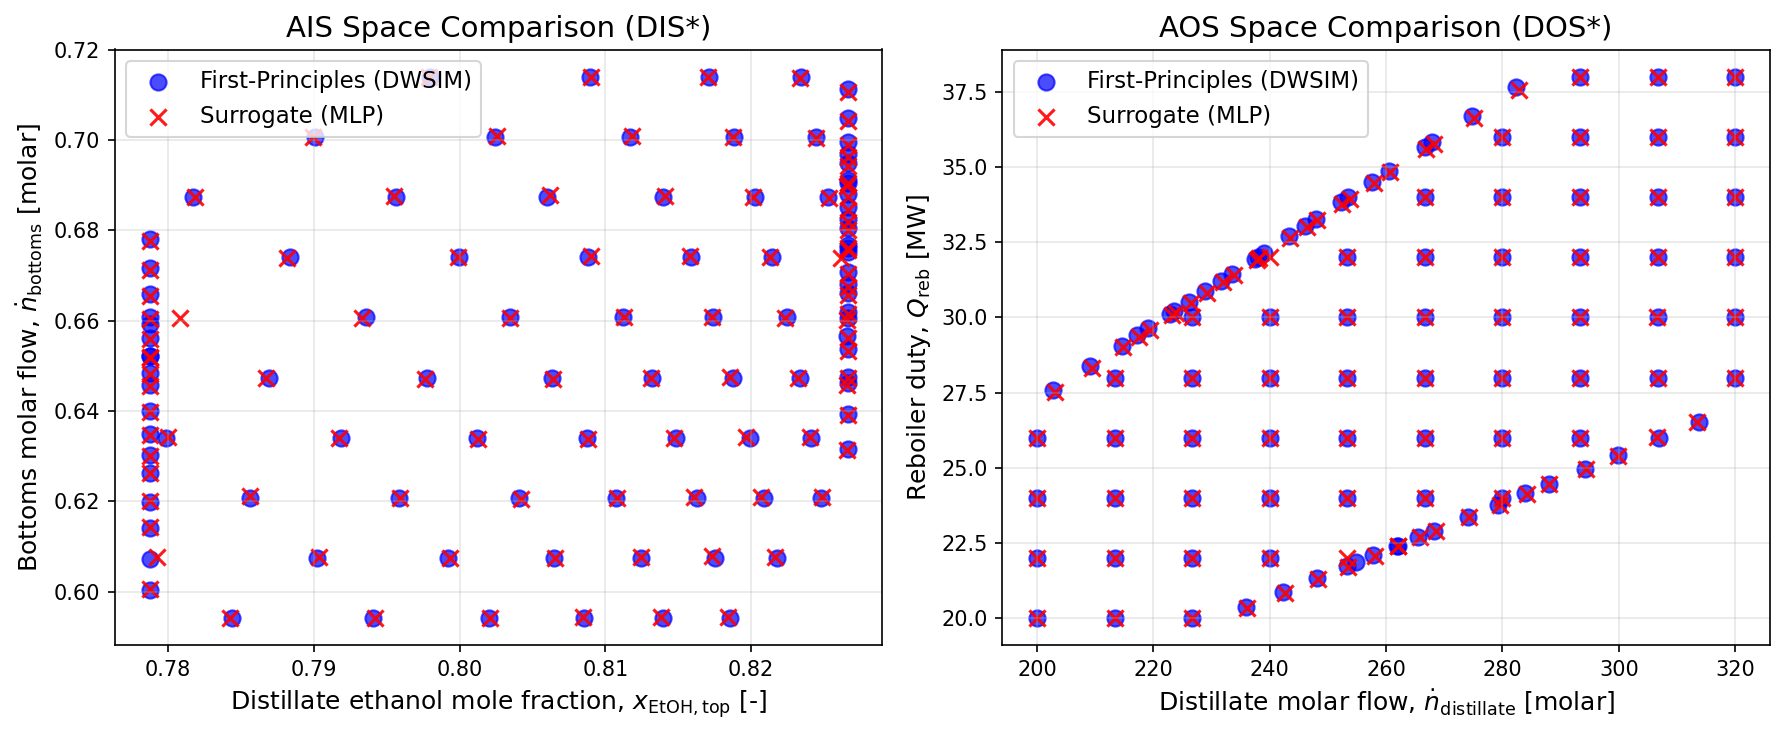

In [19]:
# ------------------------------------------------------------
# Overlay plot: Visual comparison of DIS* and DOS*
# First-principles (DWSIM) vs Surrogate (MLP)
# Ethanol–Water Distillation Column
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Filter feasible points (remove None entries)
# ------------------------------------------------------------
dis_fp = np.array([u for u in fDIS_fp if u is not None], dtype=float)
dis_surr = np.array([u for u in fDIS_surr if u is not None], dtype=float)

dos_fp = np.array([y for y in fDOS_fp if y is not None], dtype=float)
dos_surr = np.array([y for y in fDOS_surr if y is not None], dtype=float)

# ------------------------------------------------------------
# Create side-by-side plots
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ------------------------------------------------------------
# DIS* overlay — AIS space (specification space)
# AIS inputs: [x_EtOH_top, Bottoms flow]
# ------------------------------------------------------------
if dis_fp.size > 0:
    axes[0].scatter(
        dis_fp[:, 0], dis_fp[:, 1],
        c="blue", s=60, alpha=0.7, label="First-Principles (DWSIM)"
    )

if dis_surr.size > 0:
    axes[0].scatter(
        dis_surr[:, 0], dis_surr[:, 1],
        c="red", marker="x", s=60, alpha=0.9, label="Surrogate (MLP)"
    )

axes[0].set_xlabel(r"Distillate ethanol mole fraction, $x_{\mathrm{EtOH,top}}$ [-]", fontsize=12)
axes[0].set_ylabel(r"Bottoms molar flow, $\dot n_{\mathrm{bottoms}}$ [molar]", fontsize=12)
axes[0].set_title("AIS Space Comparison (DIS*)", fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# ------------------------------------------------------------
# DOS* overlay — AOS space (operating outcome space)
# AOS outputs: [Distillate flow, Reboiler duty]
# ------------------------------------------------------------
if dos_fp.size > 0:
    axes[1].scatter(
        dos_fp[:, 0], dos_fp[:, 1],
        c="blue", s=60, alpha=0.7, label="First-Principles (DWSIM)"
    )

if dos_surr.size > 0:
    axes[1].scatter(
        dos_surr[:, 0], dos_surr[:, 1],
        c="red", marker="x", s=60, alpha=0.9, label="Surrogate (MLP)"
    )

axes[1].set_xlabel(r"Distillate molar flow, $\dot n_{\mathrm{distillate}}$ [molar]", fontsize=12)
axes[1].set_ylabel(r"Reboiler duty, $Q_{\mathrm{reb}}$ [MW]", fontsize=12)
axes[1].set_title("AOS Space Comparison (DOS*)", fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# ------------------------------------------------------------
# Final layout
# ------------------------------------------------------------
plt.tight_layout()
plt.show()


## Compute Representative Design Point from DIS\*

In this final step, we compute a **representative design/operating point** from the
feasible **Desired Input Set (DIS\*)**.

The mean values of the DIS\* are used as a:
- nominal operating point,
- reference design condition,
- or initial guess for further optimization or control studies.

This provides a concise summary of the inverse operability results and a practical
setpoint that satisfies the desired output specifications.

In [20]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Build DIS* arrays (feasible input points) and compute means
# DIS* = [x_EtOH_top, n_dot_bottoms]  (as per your plot axes)
# ------------------------------------------------------------
dis_fp = np.array([u for u in fDIS_fp if u is not None], dtype=float)
dis_surr = np.array([u for u in fDIS_surr if u is not None], dtype=float)

if dis_fp.size == 0 or dis_surr.size == 0:
    raise ValueError("No feasible DIS* points found (empty fDIS_fp/fDIS_surr after filtering None).")

mean_x_top_fp, mean_nbot_fp = dis_fp.mean(axis=0)
mean_x_top_surr, mean_nbot_surr = dis_surr.mean(axis=0)

def rel_err(a, b):
    denom = abs(a) if abs(a) > 1e-12 else 1e-12
    return abs(a - b) / denom * 100.0

# ------------------------------------------------------------
# Table 1 — Mean Design Values from DIS* (Inputs)
# ------------------------------------------------------------
df_dis = pd.DataFrame({
    "Variable": [
        r"Distillate ethanol mole fraction, $x_{\mathrm{EtOH,top}}$ [-]",
        r"Bottoms molar flow, $\dot n_{\mathrm{bottoms}}$ [molar]"
    ],
    "First-Principles (DWSIM)": [
        mean_x_top_fp,
        mean_nbot_fp
    ],
    "MLP Surrogate": [
        mean_x_top_surr,
        mean_nbot_surr
    ],
    "Rel. Error [%]": [
        rel_err(mean_x_top_fp, mean_x_top_surr),
        rel_err(mean_nbot_fp, mean_nbot_surr)
    ]
})

print("\nMean Design Values from DIS*:\n")
display(
    df_dis.style
        .format({
            "First-Principles (DWSIM)": "{:.6f}",
            "MLP Surrogate": "{:.6f}",
            "Rel. Error [%]": "{:.4f}"
        })
        .hide(axis="index")  # removes the 0/1 index column
)

# ------------------------------------------------------------
# Table 2 — Computational Time (and speedup)
# ------------------------------------------------------------
df_time = pd.DataFrame({
    "Model": [
        "First-Principles (DWSIM)",
        "MLP Surrogate",
        "Speedup (× faster)"
    ],
    "Value": [
        time_fp,
        time_surrogate,
        time_fp / time_surrogate
    ]
})

print("\nComputational Time:\n")
display(
    df_time.style
        .format({
            "Value": "{:.2f}"
        })
        .hide(axis="index")
)



Mean Design Values from DIS*:



Variable,First-Principles (DWSIM),MLP Surrogate,Rel. Error [%]
"Distillate ethanol mole fraction, $x_{\mathrm{EtOH,top}}$ [-]",0.807175,0.807180,0.0005
"Bottoms molar flow, $\dot n_{\mathrm{bottoms}}$ [molar]",0.654561,0.654433,0.0194



Computational Time:



Model,Value
First-Principles (DWSIM),8346.86
MLP Surrogate,5.38
Speedup (× faster),1550.37


## Conclusion

This case study demonstrates the effectiveness of **surrogate-based operability analysis**
for a **realistic distillation process** when the problem is explicitly formulated from an
**inverse operability perspective**.

By combining a **first-principles phenomenological model** implemented in **DWSIM**
with a **data-driven MLP surrogate**, the operational behavior of an
**ethanol–water distillation column** was accurately characterized under imposed
**product-level specifications**, rather than traditional equipment-level manipulated
variables.

The results show that redefining the specification space in terms of
**distillate ethanol mole fraction** and **bottoms molar flow rate** leads to a
**genuinely two-dimensional feasible design space**, revealing clear and physically
meaningful trade-offs between **product quality**, **throughput**, and **energy
requirements**. This formulation avoids structural degeneracies often encountered in
classical operability studies and enables a robust geometric interpretation of the
achievable operating region.

The surrogate model was shown to **faithfully reproduce the feasible operating space and
the Operability Index** obtained from the high-fidelity DWSIM model, while delivering a
**computational speedup of several orders of magnitude**. Such performance gains enable
dense forward mappings, efficient inverse mappings, and rapid feasibility assessments
that would be impractical using only first-principles column simulations.

Through the computation of the **Operability Index** and the **inverse mapping
(DOS → DIS\*)**, the analysis provides quantitative insight into which combinations of
**distillate specification targets** and **bottoms throughput levels** are compatible
with the underlying process constraints. The resulting feasible design set therefore
offers actionable guidance for **column operation**, **energy–throughput trade-off
evaluation**, and **design-oriented decision making**.

Overall, this example highlights how the integration of **rigorous process simulation**,
**machine-learning surrogate models**, and **operability analysis tools such as
Opyrability** forms a powerful and scalable framework for modern separation process
engineering, effectively bridging the gap between high-fidelity models and
computationally efficient analysis workflows.


**Acknowledgements**
This notebook reflects practical experience in industrial process simulation, surrogate
modeling, and operability analysis. The author acknowledges the open-source community
behind DWSIM, Opyrability, and scikit-learn for enabling reproducible and accessible
advanced process engineering workflows.